#### Compare abstract lengths between popular journals: considers condensed matter.

In [29]:
%pylab inline
import sys
sys.path.append('../')

import nltk
from nltk.corpus import stopwords

import re
import operator

s=stopwords.words('english') + ['']

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

engine = create_engine("sqlite:///../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

category_name = "cond-mat"

Populating the interactive namespace from numpy and matplotlib


In [30]:
#How many articles have journal references?

query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref==None)
resultNone = query.all()
print len(resultNone)

query2 = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref!=None)
resultSome = query2.all()
print len(resultSome)



99289
132840


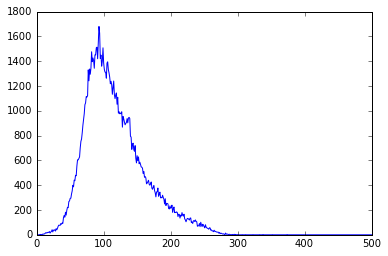

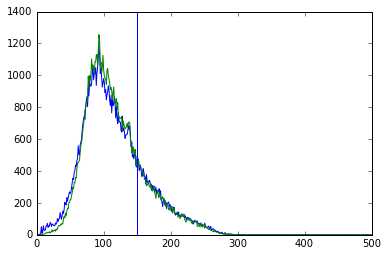

In [3]:
#Do aggregate abstract lengths from referenced vs nonreferenced articles vary?

abstract_lengths = np.zeros(5000)
too_large = 0
for item in resultSome:
    abstract = item.article.abstract
    wordnum = len(abstract.split(' '))
    if wordnum < len(abstract_lengths):
        abstract_lengths[wordnum]+=1
    else:
        too_large += 1

plot(np.arange(abstract_lengths.size),abstract_lengths)
xlim(0,500)
show()

abstract_lengths_none = np.zeros(5000)
too_large = 0
for item in resultNone:
    abstract = item.article.abstract
    wordnum = len(abstract.split(' '))
    if wordnum < len(abstract_lengths):
        abstract_lengths_none[wordnum]+=1
    else:
        too_large += 1

plot(np.arange(abstract_lengths_none.size),abstract_lengths_none,color = 'blue')
plot(np.arange(abstract_lengths.size),abstract_lengths*float(len(resultNone))/len(resultSome), color = 'green')
axvline(150)
xlim(0,500)
show()

#Answer: Not really.  

In [6]:
#What are the most common journals to the field?
query = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Category.name.like('%cond-mat%'))\
                    .order_by(Article.id)
results = query.all()
journals = {}
annoying_bits = ['Al', 'vol','Vol','pp','pages', 'ue',' p',' v','no','No','ISSN','iss',' n', 'bf', 'Iss', 'Issue']
journals['None']=0
for item in results:
    jname_all = item.article.journal_ref
    if jname_all is not None:
        jname = " ".join(re.findall("[a-zA-Z]+", jname_all))
        for bit in annoying_bits:
            jname=jname.replace(bit,'')
        if jname in journals:
            journals[jname] = journals[jname]+1
        else:
            journals[jname] = 0
    else:
        journals['None'] = journals['None']+1

In [9]:
#Ok, list those popular journals.
print sorted(journals.items(),key=operator.itemgetter(1),reverse=True)

[('None', 99289), (u'Phys Rev B', 26670), (u'Phys Rev Lett', 15503), (u'Phys Rev E', 6741), (u'Phys Rev A', 4917), (u'Phys Rev B R', 3210), (u'Physical Review B', 2793), (u'Al Phys Lett', 2198), (u'J Phys Condens Matter', 1960), (u'J Chem Phys', 1884), (u'New J Phys', 1795), (u'J Phys Soc Jpn', 1616), (u'J Stat Mech P', 1489), (u'Eur Phys J B', 1267), (u'Physical Review Letters', 1253), (u'EPL', 1241), (u'Europhys Lett', 1133), (u'Physica A', 1015), (u'Physical Review E', 966), (u'J Al Phys', 892), (u'J Phys A Math Theor', 839), (u'J Phys A', 730), (u'Phys Rev D', 696), (u'Alied Physics Letters', 683), (u'Phys Rev B ', 676), (u'Nature Physics', 578), (u'Phys Rev A R', 571), (u'Nucl Phys B', 527), (u'J Stat Phys', 526), (u'Nature Communications', 516), (u'Physica C', 513), (u'Phys Rev E R', 487), (u'Scientific Reports', 487), (u'Phys Lett A', 472), (u'Soft Matter', 433), (u'Europhysics Letters', 430), (u'Phys Rev X', 422), (u'New Journal of Physics', 408), (u'Physical Review A', 372), (

In [10]:
#These are pretty popular:
journals = [None,\
            ["Phys Rev B", "Physical Review B","PRB"], \
            ["Phys Rev Lett", "Physical Review Letters","PRL", "Phys. Rev. Lett."], \
            ["Phys Rev E","Physical Review E","PRE", "Phys. Rev. E"], \
            ["Phys Rev A","Physical Review A", "PRA", "Phys. Rev. A"], \
            ["Phys Rev D","Physical Review D","PRD", "Phys. Rev. D"],\
            ["Phys Lett", "Physical Letters", "Phys. Lett."], \
            "J Phys Condens Matter",\
            ["J Chem Phys","Journal of Chemical Physics", "J. Chem. Phys."], \
            ["New J Phys","New Journal of Physics", "New J. Phys."], \
            ["Nature","Nat", "Nat."],\
            "Science"]    

In [11]:
#Count up how many articles are captured by above journal list.
result_by_journal=[]
for idx,j_list in enumerate(journals):
    if type(j_list) == str:
        query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref.like("%"+j_list+"%"))
        result_by_journal.insert(idx,query.all())
    elif j_list == None:
        query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref==None)
        result_by_journal.insert(idx,query.all())
    else:
        for k in range(len(j_list)):
            query = session.query(Article_Category)\
                .join(Category).join(Article)\
                .filter(Category.name.like('%'+category_name+'%'))\
                .filter(Article.journal_ref.like("%"+j_list[k]+"%"))
            if k==0:
                result_by_journal.insert(idx,query.all())
            else:
                result_by_journal[idx]+=query.all()
                
total_lengths = 0
for k in range(len(result_by_journal)):
    print len(result_by_journal[k])
    total_lengths += len(result_by_journal[k])
total_lengths -= len(result_by_journal[0])
print total_lengths/float(99289) #Number is total referenced articles.  Tsk tsk, hardcoding numbers.

99289
4179
16687
9104
6009
334
4367
5
2360
2256
6511
1718
0.539133237317


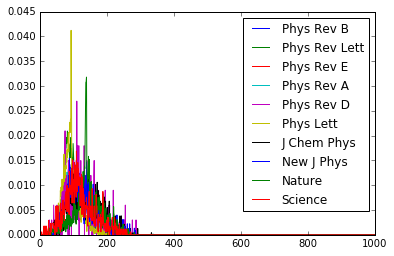

In [12]:
#Print them abstract lengths (by journal).  But ignore that one journal with 5 articles, it's the worst.  Also normalize.
too_large = 0
for idx in [1,2,3,4,5,6,8,9,10,11]:
    abstract_lengths = np.zeros(1000)
    for item in result_by_journal[idx]:
        abstract = item.article.abstract
        wordnum = len(abstract.split(' '))
        if wordnum < len(abstract_lengths):
            abstract_lengths[wordnum]+=1
        else:
            too_large += 1

    abstract_lengths /= float(len(result_by_journal[idx]))
    label = ''
    if type(journals[idx]) == str:
        jlabel = journals[idx]
    else:
        jlabel = journals[idx][0]
            
    plot(np.arange(abstract_lengths.size), abstract_lengths, label = jlabel)

legend()
show()
    
    
                         



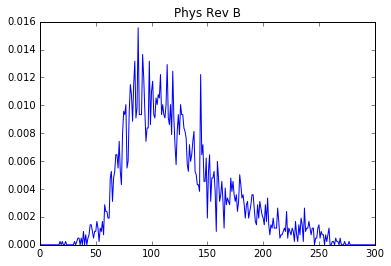

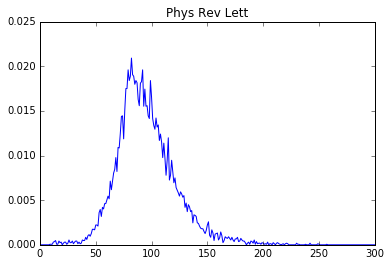

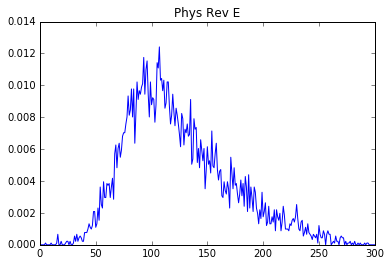

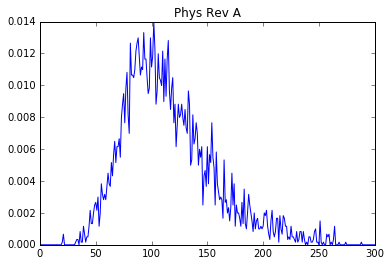

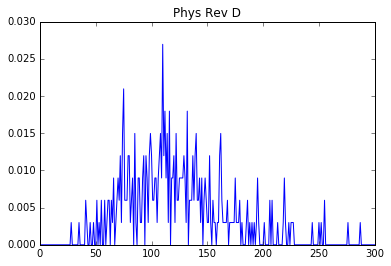

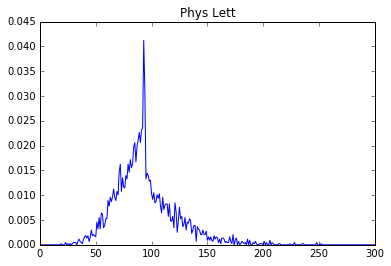

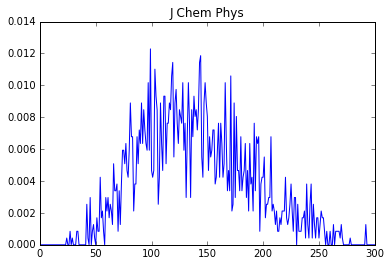

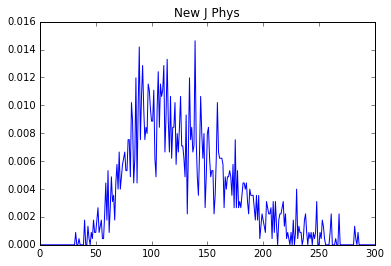

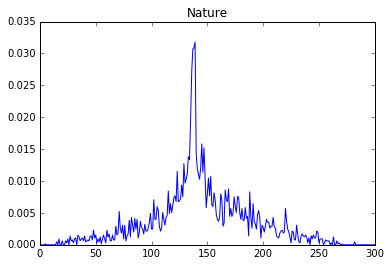

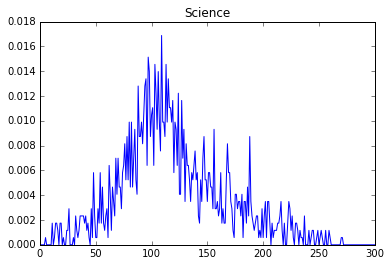

In [13]:
#Can't even with all those lines on top of each other.  Let's print them out separately.
too_large = 0
for idx in [1,2,3,4,5,6,8,9,10,11]:
    abstract_lengths = np.zeros(1000)
    for item in result_by_journal[idx]:
        abstract = item.article.abstract
        wordnum = len(abstract.split(' '))
        if wordnum < len(abstract_lengths):
            abstract_lengths[wordnum]+=1
        else:
            too_large += 1

    abstract_lengths /= float(len(result_by_journal[idx]))
    label = ''
    if type(journals[idx]) == str:
        jlabel = journals[idx]
    else:
        jlabel = journals[idx][0]
            
    plot(np.arange(abstract_lengths.size), abstract_lengths)
    title(jlabel)
    xlim(0,300)
    show()




##### So, in conclusion:
1) Abstract lengths are all probably similar.

2) Nature and phys letters have some length restrictions going on - so much so that peaks show up in the all-journal-lengths abstract plot.

3) PRL authors don't have the same abstract length requirement (?) but possibly due to page limits, abstracts are rather more terse. PRA/B/C etc are pretty qualitatively similar. The limit of writing shame is ~50 words.

16
0


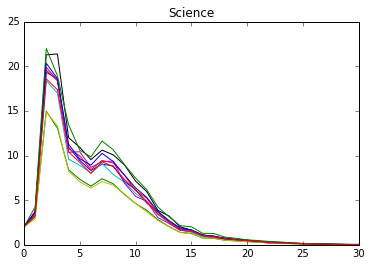

In [17]:
#Lolz, I lied.  That wasn't the end.  There's one more thing - science-y word lengths?
too_large = 0
mathword = 0
for idx in [1,2,3,4,5,6,8,9,10,11]:
    word_lengths = np.zeros(100)
    for item in result_by_journal[idx]:
        abstract = item.article.abstract
        words = abstract.split(' ')
        for el in words:
            if len(el) < len(word_lengths):
                word_lengths[len(el)]+=1
            else:
                too_large += 1
                #print el
            if el == "%$%$%":
                mathword +=1

    word_lengths /= float(len(result_by_journal[idx]))
    label = ''
    if type(journals[idx]) == str:
        jlabel = journals[idx]
    else:
        jlabel = journals[idx][0]
            
    plot(np.arange(word_lengths.size), word_lengths)
    title(jlabel)
    xlim(0,30)
print too_large
print mathword
   
 

(0, 30)

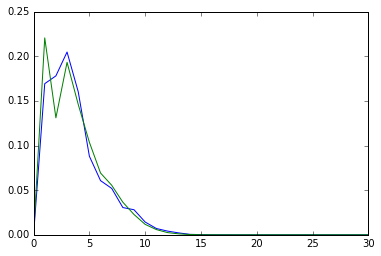

In [26]:
#Ok, but is this, like, normal?  Let's compare our typical science graph to some other human language things.

emma = nltk.corpus.gutenberg.words('austen-emma.txt')
wordlengths_emma = np.zeros(50)
leaves = nltk.corpus.gutenberg.words('whitman-leaves.txt')
wordlengths_leaves = np.zeros(50)
for el in emma:
    wordlengths_emma[len(el)]+=1
for el in leaves:
    wordlengths_leaves[len(el)]+=1
    
plot(np.arange(wordlengths_emma.size),wordlengths_emma/float(len(emma)), color = 'blue')
plot(np.arange(wordlengths_leaves.size),wordlengths_leaves/float(len(leaves)), color = 'green')
xlim(0,30)
